In [2]:
import zipfile

# Download zip file of pizza_steak images
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [1]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 1 images in 'pizza_steak'.
There are 15 directories and 1 images in 'pizza_steak/test'.
There are 0 directories and 123 images in 'pizza_steak/test/Cat'.
There are 0 directories and 122 images in 'pizza_steak/test/Dog'.
There are 0 directories and 129 images in 'pizza_steak/test/Dolphin'.
There are 0 directories and 129 images in 'pizza_steak/test/Giraffe'.
There are 0 directories and 125 images in 'pizza_steak/test/Bear'.
There are 0 directories and 137 images in 'pizza_steak/test/Zebra'.
There are 0 directories and 135 images in 'pizza_steak/test/Panda'.
There are 0 directories and 129 images in 'pizza_steak/test/Tiger'.
There are 0 directories and 137 images in 'pizza_steak/test/Bird'.
There are 0 directories and 126 images in 'pizza_steak/test/Kangaroo'.
There are 0 directories and 130 images in 'pizza_steak/test/Horse'.
There are 0 directories and 131 images in 'pizza_steak/test/Cow'.
There are 0 directories and 127 images in 'pizza_steak/test/Deer'.
Th

In [2]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/Lion"))

num_steak_images_train

131

In [3]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['.DS_Store' 'Bear' 'Bird' 'Cat' 'Cow' 'Deer' 'Dog' 'Dolphin' 'Elephant'
 'Giraffe' 'Horse' 'Kangaroo' 'Lion' 'Panda' 'Tiger' 'Zebra']


In [4]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = target_dir+target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

    return img

Image shape: (224, 224, 3)


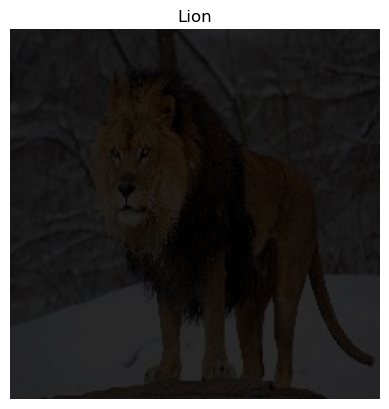

In [8]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="Lion")

In [9]:
# Setup data inputs
from keras.src.legacy.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 1944 images belonging to 15 classes.
Testing images:
Found 1944 images belonging to 15 classes.


In [10]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [48]:
import tensorflow as tf
import tensorflow_hub as hub
import keras

In [49]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [50]:
def create_model(model_url, num_classes=10):
    """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    
    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in output layer,
        should be equal to number of target classes, default 10.
  
    Returns:
      An uncompiled Keras Sequential model with model_url as feature
      extractor layer and Dense output layer with num_classes outputs.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze the underlying patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer, # use the feature extraction layer as the base
        keras.layers.Dense(num_classes, activation='softmax', name='output_layer')   
    ])

    return model

In [51]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x17ea56360> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [55]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import layers

# Define the image shape and batch size
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

def create_model(model_url, num_classes=10):
    """Takes a TensorFlow Hub URL and creates a Keras model with it.
    
    Args:
      model_url (str): A TensorFlow Hub feature extraction URL.
      num_classes (int): Number of output neurons in output layer,
        should be equal to number of target classes, default 10.
  
    Returns:
      An uncompiled Keras model with model_url as feature
      extractor layer and Dense output layer with num_classes outputs.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze the underlying patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE + (3,)) # define the input image shape

    # Define the input layer
    inputs = tf.keras.Input(shape=IMAGE_SHAPE + (3,))

    # Pass the inputs to the feature extractor layer
    x = feature_extractor_layer(inputs)

    # Add a dense layer for our own output
    outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Assuming you have the following variables already defined:
# resnet_url, train_data_10_percent

# Create the model
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Define num_classes from the train_data_10_percent dataset
num_classes = train_data_10_percent.num_classes if hasattr(train_data_10_percent, 'num_classes') else 10
num_classes
# resnet_model = create_model(resnet_url, num_classes=num_classes)
# 
# # Compile the model
# resnet_model.compile(loss='categorical_crossentropy',
#                      optimizer=tf.keras.optimizers.Adam(),
#                      metrics=['accuracy'])
# 
# # Print model summary
# resnet_model.summary()


15

In [56]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

ValueError: Exception encountered when calling layer 'feature_extraction_layer' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'feature_extraction_layer' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_3>
  • training=None